> pandas provides a flexible groupby interface, enabling you to slice, dice, and summarize datasets

# 10.1 GroupBy Mechanics

The term **split-apply-combine** is for describing group operations

In the first stage of the process, data contained in a pandas object, is split into groups based on one or more keys that you provide. The splitting is performed on a particular axis of an object

Once this is done, a function is applied to each group, producing a new value. Finally, the results of all those function applications are combined into a result object

See Figure 10-1 for a mockup of a simple group aggregation



<p align='center'>
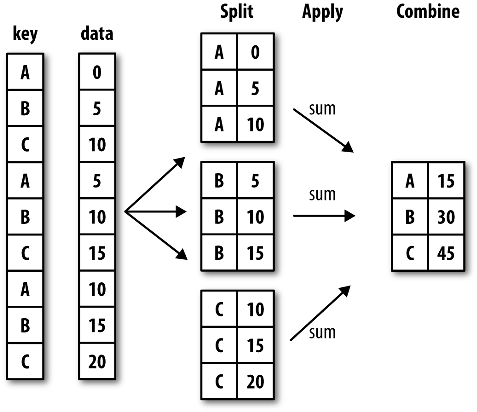
</p>
Figure 10-1. Illustration of a group aggregation

Each grouping key can take many forms, and **the keys do not have to be all of the same type:**

* A **list or array of values that is the same length as the axis being grouped**

* A **value indicating a column name** in a DataFrame

* A **dict or Series giving a correspondence between the values on the axis being grouped and the group names**

* A **function to be invoked on the axis index** or the individual labels in the index

Note that the latter three methods are shortcuts for producing an array of values to be used to split up the object

To get started, here is a small tabular dataset as a DataFrame:

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [3]:
df

,key1,key2,data1,data2
0,a,one,0.938807,0.305916
1,a,two,1.676105,1.225880
2,b,one,0.631528,0.552726
3,b,two,0.059549,0.737652
4,a,one,-0.099246,0.511620


Suppose you wanted to** compute the mean of the data1** column **using the labels from key1**

There are a number of ways to do this. One is to access data1 and call groupby with the column (a Series) at key1:

In [4]:
grouped = df['data1'].groupby(df['key1'])

In [5]:
grouped

This grouped variable is now a **GroupBy object.** **It has not actually computed anything yet** except for some intermediate data about the group key df['key1']

The idea is that **this object has all of the information needed to then apply some operation to each of the groups**

For example, to compute group means we can call the GroupBy’s mean method:



In [6]:
grouped.mean()

key1
a    0.838556
b    0.345539
Name: data1, dtype: float64

The important thing here is that the data **(a Series) has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the key1 column**

The result index has the name 'key1' because the DataFrame column df['key1'] did

If instead we had passed multiple arrays as a list, we’d get something different:

In [7]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [8]:
means

key1  key2
a     one     0.419781
      two     1.676105
b     one     0.631528
      two     0.059549
Name: data1, dtype: float64

Here **we grouped the data using two keys, and the resulting Series now has a hierarchical index **consisting of the unique pairs of keys observed:

In [9]:
means.unstack()

key2,one,two
key1,,
a,0.419781,1.676105
b,0.631528,0.059549


In this example, the group keys are all Series, though they could be any arrays of the right length:

In [10]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

In [11]:
years = np.array([2005, 2005, 2006, 2005, 2006])

In [12]:
df['data1'].groupby([states, years]).mean()

California  2005    1.676105
            2006    0.631528
Ohio        2005    0.499178
            2006   -0.099246
Name: data1, dtype: float64

Frequently the grouping information is found in the same DataFrame as the data you want to work on

In that case, **you can pass column names (whether those are strings, numbers, or other Python objects) as the group keys:**

In [13]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.838556,0.681139
b,0.345539,0.645189


You may have noticed in the first case df.groupby('key1').mean() that there is no key2 column in the result

Because df['key2'] is not numeric data, it is said to be a nuisance column, which is therefore excluded from the result



In [14]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.419781  0.408768
     two   1.676105  1.225880
b    one   0.631528  0.552726
     two   0.059549  0.737652

By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset

Regardless of the objective in using groupby, a generally useful GroupBy method is **size**, which **returns a Series containing group sizes:**

In [15]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

Take note that any **missing values in a group key will be excluded from the result**

## Iterating Over Groups

The **GroupBy object supports iteration, generating a sequence of 2-tuples containing the group name along with the chunk of data.** Consider the following:

In [16]:
for name, group in df.groupby('key1'):
  print(name)
  print(group)

a
  key1 key2     data1     data2
0    a  one  0.938807  0.305916
1    a  two  1.676105  1.225880
4    a  one -0.099246  0.511620
b
  key1 key2     data1     data2
2    b  one  0.631528  0.552726
3    b  two  0.059549  0.737652


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [17]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
  print((k1, k2))
  print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one  0.938807  0.305916
4    a  one -0.099246  0.511620
('a', 'two')
  key1 key2     data1    data2
1    a  two  1.676105  1.22588
('b', 'one')
  key1 key2     data1     data2
2    b  one  0.631528  0.552726
('b', 'two')
  key1 key2     data1     data2
3    b  two  0.059549  0.737652


Of course, you can choose to do whatever you want with the pieces of data

A recipe you may find useful is computing a dict of the data pieces as a one-liner:

In [18]:
pieces = dict(list(df.groupby('key1')))

In [23]:
pieces['b']

,key1,key2,data1,data2
2,b,one,0.631528,0.552726
3,b,two,0.059549,0.737652


By default groupby groups on axis=0, but you can group on any of the other axes

For example, we could **group the columns of our example df here by dtype** like so:

In [24]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [25]:
grouped = df.groupby(df.dtypes, axis=1)

We can print out the groups like so:

In [26]:
for dtype, group in grouped:
  print(dtype)
  print(group)

float64
      data1     data2
0  0.938807  0.305916
1  1.676105  1.225880
2  0.631528  0.552726
3  0.059549  0.737652
4 -0.099246  0.511620
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


## Selecting a Column or Subset of Columns

**Indexing a GroupBy object created from a DataFrame with a column name** or array of column names has the effect of column subsetting for aggregation

In [28]:
df.groupby('key1')['data1']
df.groupby('key1')['data2']

are syntactic sugar for:

In [30]:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

Especially for large datasets, it may be **desirable to aggregate only a few columns**

For example, in the preceding dataset, to compute means for just the data2 column and get the result as a DataFrame, we could write:

In [31]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.408768
     two   1.225880
b    one   0.552726
     two   0.737652

The object returned by this indexing operation **is a grouped DataFrame if a list or array is passed** or a grouped Series if only a single column name is passed as a scalar:

In [32]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

In [33]:
s_grouped

In [34]:
s_grouped.mean()

key1  key2
a     one     0.408768
      two     1.225880
b     one     0.552726
      two     0.737652
Name: data2, dtype: float64

##Grouping with Dicts and Series

**Grouping information may exist in a form other than an array**

Let’s consider another example DataFrame:

In [35]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [36]:
people.iloc[2:3, [1, 2]] = np.nan

In [37]:
people

,a,b,c,d,e
Joe,-1.115877,-0.182294,-1.593646,0.870928,1.301363
Steve,-0.072772,-0.208314,-2.097886,1.029306,0.131661
Wes,0.901333,NaN,NaN,-0.400929,-1.384045
Jim,-0.422101,-0.807821,-1.105222,1.942403,1.171057
Travis,0.272132,-1.802614,-0.456115,0.105334,1.004137


Now, suppose I have a group correspondence for the columns and want to sum together the columns by group:

In [38]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f': 'orange'}

Now, you could construct an array from this dict to pass to groupby, but **instead we can just pass the dict**

(I included the key 'f' to highlight that unused grouping keys are OK):

In [39]:
by_column = people.groupby(mapping, axis=1)

In [40]:
by_column.sum()

,blue,red
Joe,-0.722719,0.003193
Steve,-1.068580,-0.149425
Wes,-0.400929,-0.482712
Jim,0.837181,-0.058864
Travis,-0.350781,-0.526345


The same functionality holds for Series, which can be viewed as a fixed-size mapping:

In [41]:
map_series = pd.Series(mapping)

In [42]:
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [43]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


##Grouping with Functions

Using Python functions is a more generic way of defining a group mapping compared with a dict or Series

**Any function passed as a group key will be called once per index value, with the return values being used as the group names**

More concretely, consider the example DataFrame from the previous section, which has people’s first names as index values

**Suppose you wanted to group by the length of the names;** while you could compute an array of string lengths, it’s simpler to just pass the len function:

In [44]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.636644,-0.990115,-2.698868,2.412401,1.088375
5,-0.072772,-0.208314,-2.097886,1.029306,0.131661
6,0.272132,-1.802614,-0.456115,0.105334,1.004137


Mixing functions with arrays, dicts, or Series is not a problem as everything gets converted to arrays internally:

In [45]:
key_list = ['one', 'one', 'one', 'two', 'two']

In [46]:
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -1.115877 -0.182294 -1.593646 -0.400929 -1.384045
  two -0.422101 -0.807821 -1.105222  1.942403  1.171057
5 one -0.072772 -0.208314 -2.097886  1.029306  0.131661
6 two  0.272132 -1.802614 -0.456115  0.105334  1.004137

##Grouping by Index Levels

A final convenience for hierarchically indexed datasets is the ability to **aggregate using one of the levels of an axis index.** Let’s look at an example:

In [47]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                     [1, 3, 5, 1, 3]],
                                    names=['city', 'tenor'])

In [49]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)

In [51]:
hier_df

city         US                            JP          
tenor         1         3         5         1         3
0     -0.089537 -0.719609  0.453548  1.892616  0.274320
1      0.121835 -0.606909  1.157534  0.424874 -1.856506
2      0.741874 -0.522078  1.105456 -1.049105 -0.864719
3     -0.416484 -0.021897  1.707395  1.328012 -0.878354

**To group by level, pass the level number or name using the level keyword:**

In [52]:
hier_df.groupby(level='city', axis=1).count()

city,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


# 10.2 Data Aggregation

Aggregations refer to any data transformation that produces scalar values from arrays

Many common aggregations, are found in Table 10-1

Table 10-1. Optimized groupby methods
<p align='center'>
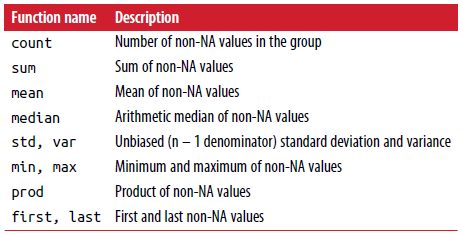
</p>